# CS470 Assignment 3
In this assignment, we will first design a **Markov Decision Process (MDP)** for a *gridworld* environment. Then, on top of it, we implement and run **dynamic programming (DP)** approaches. Note that you must run this file on **Google Chrome**, otherwise you may not be able to play recorded videos.

# Requirements for initialization
We will first install dependencies and declare auxiliary functions for visualization

In [1]:
#@title Run the cell below to install dependencies

#Install dependencies to visualize agents 
!pip install pyglet==1.5.1  &> /dev/null
!apt install -y python-opengl ffmpeg xvfb &> /dev/null
!pip install pyvirtualdisplay &> /dev/null
!pip install gymnasium &> /dev/null
!pip install numpy &> /dev/null

# !pip install huggingface_hub &> /dev/null
!pip install pickle5 &> /dev/null
!pip install pyyaml==6.0 &> /dev/null 
!pip install imageio imageio_ffmpeg &> /dev/null

!apt-get install -y python x11-utils &> /dev/null
!pip install scikit-video ffio pyrender &> /dev/null
# !pip install tensorflow_probability==0.12.0 &> /dev/null

import numpy as np
import gymnasium as gym
from gymnasium import error, spaces, utils
from gymnasium.utils import seeding
from typing import List, Optional

import imageio, random, copy
import sys, time, os, base64, io
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import IPython, functools, matplotlib, cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image as Image
from tqdm import tqdm

from IPython.display import HTML

In [2]:
#@title Run the cell below to declare auxiliary functions

from IPython.display import HTML
def eval_policy(env, policy=None, num_episodes=10):
    """Evaluate a model (i.e., policy) running on the input environment"""
    # env = gym.make(env_name)
    obs, _ = env.reset()
    prev_obs = obs
    counter = 0
    done = False
    num_runs = 0
    episode_reward = 0
    episode_rewards = []
    while num_runs < num_episodes:
        if policy is not None:
            action = policy(obs)
        else:
            action = env.action_space.sample()
        
        prev_obs = obs
        obs, reward, done, truncated, info = env.step(action)
        counter += 1
        episode_reward += reward
        if done or truncated:
            counter = 0
            num_runs += 1
            obs, _ = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0        
    return episode_rewards

def save_video_of_model(env_name, model=None, suffix="", num_episodes=10):
    """
    Record a video that shows the behavior of an agent following a model 
    (i.e., policy) on the input environment
    """
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs, _ = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    num_runs = 0
    returns = 0
    while num_runs < num_episodes:
        frame = env.render()
        output_video.writeFrame(frame)

        if "Gridworld" in env_name:
            input_obs = obs
        else:
            raise ValueError(f"Unknown env for saving: {env_name}")

        if model is not None:
            action = model(input_obs)
        else:
            action = env.action_space.sample()


        prev_obs = obs
        obs, reward, done, truncated, info = env.step(action)
        counter += 1
        returns += reward
        if done or truncated:
            num_runs += 1
            obs, _ = env.reset()

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename, returns / num_runs

def play_video(filename, width=None):
    """Play the input video"""

    from base64 import b64encode
    mp4 = open(filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html = """
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url
    return  html


def render_value_map_with_action(env, Q, policy=None):
    '''
    Render a state (or action) value grid map.
    V[s] = max(Q[s,a])
    '''
    Q = Q.copy()
    from matplotlib.colors import LinearSegmentedColormap
    n = env.grid_map_shape[0]
    m = env.grid_map_shape[1]
    
    if len(np.shape(Q))>1:
        V = np.amax(Q, axis=1) 
        V = V.reshape((m,n)).T
    else:
        V = Q.reshape((m,n)).T

    import itertools
    symbol = ['.', '^','v', '<', '>']
    x = range(0, env.grid_map_shape[0])
    y = range(0, env.grid_map_shape[1])

    min_val = V[0,0]
    obstacles = np.zeros([n,m])
    for obstacle in env.obstacles:
        posx = obstacle % env.grid_map_shape[0]
        posy = obstacle // env.grid_map_shape[0]
        V[posx, posy] = min_val
        obstacles[posx, posy] = 1

    plt.imshow(V, cmap='jet', interpolation='nearest')
    for s in range(env.observation_space.n):
        twod_state = env.serial_to_twod(s)
        state_inds = s
        best_action = policy(s)
        plt.plot([twod_state[1]], [twod_state[0]], marker=symbol[best_action], linestyle='none', color='k')

    dark_low = ((0., 1., 1.),
            (.3, 1., 0.),
            (1., 0., 0.))
            
    cdict = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low}

    cdict3 = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low,
        'alpha': ((0.0, 0.0, 0.0),
                  (0.3, 0.0, 1.0),
                  (1.0, 1.0, 1.0))
        }
    dropout_high = LinearSegmentedColormap('Dropout', cdict3)
    plt.imshow(obstacles, cmap = dropout_high)
    plt.show()

def collect_traj(env, policy=None, num_episodes=10):
    """Collect trajectories (rollouts) following the input policy"""
    obs, _ = env.reset()
    prev_obs = obs
    done = False
    num_runs = 0
    episode_rewards = []
    episode_reward = 0
    traj = []
    trajs = []

    while num_runs < num_episodes:
        input_obs = obs
        if policy is not None:
            action = policy(input_obs)
        else:
            action = env.action_space.sample()
        prev_obs = obs
        traj.append(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        if done or truncated:
            num_runs += 1
            traj.append(obs)
            trajs.append(traj)

            traj = []
            obs, _ = env.reset()

            episode_rewards.append(episode_reward)
            episode_reward = 0
    return trajs#, episode_rewards

def plot_trajs(env, trajectories):
    """Plot the input trajectories"""
    from matplotlib.colors import LinearSegmentedColormap
    n = env.grid_map_shape[0]
    m = env.grid_map_shape[1]
    V = np.zeros([n,m])
    obstacles = np.zeros([n,m])
    for obstacle in env.obstacles:
        posx = obstacle % env.grid_map_shape[0]
        posy = obstacle // env.grid_map_shape[0]
        obstacles[posx, posy] = 1
    dark_low = ((0., 1., 1.),
            (.3, 1., 0.),
            (1., 0., 0.))
    cdict = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low}
    cdict3 = {'red':  dark_low,
        'green': dark_low,
        'blue': dark_low,
        'alpha': ((0.0, 0.0, 0.0),
                  (0.3, 0.0, 1.0),
                  (1.0, 1.0, 1.0))
        }
    dropout_high = LinearSegmentedColormap('Dropout', cdict3)
    plt.imshow(obstacles, cmap = dropout_high)
    for trajectory in trajectories:
        traj_2d = np.array([ env.serial_to_twod(s) for s in trajectory ])
        x = traj_2d[:, 0]
        y = traj_2d[:, 1]
        plt.plot(y, x, alpha=0.1, color='r')
    #plt.gca().invert_yaxis()
    plt.show()

def plot_grid(env):
    """Plot the input trajectories"""
    from matplotlib.colors import LinearSegmentedColormap
    n = env.grid_map_shape[0]
    m = env.grid_map_shape[1]
    V = np.zeros([n,m])
    grid_map = np.zeros([n,m])
    # for obstacles
    for obstacle in env.obstacles:
        posx = obstacle % env.grid_map_shape[0]
        posy = obstacle // env.grid_map_shape[0]
        grid_map[posx, posy] = 1
    # for trap
    for trap in env.traps:
        posx = trap % env.grid_map_shape[0]
        posy = trap // env.grid_map_shape[0]
        grid_map[posx, posy] = -1

    # create discrete colormap
    cmap = colors.ListedColormap(['red', 'white', 'black'])
    bounds = [-1.5,-0.5, 0.5,1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.imshow(grid_map, cmap = cmap, norm=norm)
    #plt.pcolormesh(grid_map, edgecolors='k', linewidth=2, cmap = cmap, norm=norm)

    x1 = range(env.grid_map_shape[0])
    y1 = range(env.grid_map_shape[1])

    for i in range(env.grid_map_shape[0]):
        for j in range(env.grid_map_shape[1]):
            binvalue = int(j*env.grid_map_shape[0]+i)
            plt.text(y1[j] + 0.0, 
                    x1[i] + 0.0, 
                    binvalue,
                    color='white' if binvalue in env.obstacles else 'black',
                    ha='center', va='center', size=8)

    plt.xticks([])
    plt.yticks([])
    plt.show()


# Problem 1: Markov Decision Process
In this problem, you design an MDP for a stochastic version of *grid-world* environment. You will implement *transition_model*, *compute_reward*, *is_done* and *step* functions following the rules defined in the assignment PDF.

In [3]:
class BaseGridEnv(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array'],
                "render_fps": 4}
    def __init__(self, render_mode='rgb_array', size=[8,10], start=None,
                 epsilon=0.2, obstacle=None, trap=None):
        """
        An initialization function

        Parameters
        ----------
        size: a list of integers
            the dimension of 2D grid environment
        start: integer
            start state (i.e., location)
        epsilon: float
            the probability of taking random actions
        obstacle: 

        """
        self.render_mode = render_mode
        self.grid_map_shape = [size[0], size[1]]  # The size of the map
        self.epsilon = epsilon  # action-failure probability
        self.obstacles = obstacle   # list of obstacle positions
        self.traps = trap # list of trap positions
        
        ''' set observation space and action space '''
        self.observation_space = spaces.Discrete( size[0] * size[1])
        self.action_space = spaces.Discrete( 5 )
    
        self.start_state = 0
        self.terminal_state = size[0] * size[1] - 1

    def serial_to_twod(self, ind):
        """Convert a serialized state number to a 2D map's state coordinate"""
        return np.array( [ ind % self.grid_map_shape[0], ind // self.grid_map_shape[0]])

    def twod_to_serial(self, twod):
        """Convert a 2D map's state coordinate to a serialized state number"""
        return np.array( twod[1]* self.grid_map_shape[0] + twod[0])

    def reset(self, 
              *,
              seed: Optional[int] = None,
              options: Optional[dict] = None,):
        """Rest the environment by initializaing the start state """
        super().reset(seed=seed)
        self.observation = self.start_state
        return self.observation, {'prob': 1}

    def render(self):
        """Render the agent state"""
        pixel_size = 20
        img = np.zeros([ pixel_size * self.grid_map_shape[0], pixel_size * self.grid_map_shape[1],3], dtype=np.uint8)
        for obstacle in self.obstacles:
          pos_x, pos_y = self.serial_to_twod(obstacle)
          img[pixel_size*pos_x: pixel_size*(1+pos_x), pixel_size*pos_y: pixel_size*(1+pos_y)] += np.array([255,0,0], dtype=np.uint8)
        agent_state = self.serial_to_twod(self.observation)   
        agent_target_state = self.serial_to_twod(self.terminal_state)
        img[pixel_size*agent_state[0]: pixel_size*(1+agent_state[0]), pixel_size*agent_state[1]: pixel_size*(1+agent_state[1])] += np.array([0,0,255], dtype=np.uint8)
        img[pixel_size*agent_target_state[0]: pixel_size*(1+agent_target_state[0]), pixel_size*agent_target_state[1]: pixel_size*(1+agent_target_state[1])] += np.array([0,255,0], dtype=np.uint8)
        if self.render_mode == 'human':
          fig = plt.figure(0)
          plt.clf()
          plt.imshow(img, cmap='gray')
          fig.canvas.draw()
          plt.pause(0.01)
        if self.render_mode == 'rgb_array':
          return img
        return 

    def _close_env(self):
        """Close the environment screen"""
        plt.close(1)
        return


Define the target grid environment for this assignment.

In [4]:
class GridEnv(BaseGridEnv):
    """
    A grid-world environment.
    """
    def transition_model(self, state, action):
        """
        A transition model that return a list of probabilities of transitions
        to next states when the agent select 'action' at the 'state': T(s' | s,a)

        In our envrionemnt, if the state is in traps or in a goal, 
        it will stay in its state at any action

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index        

        Returns
        -------  
        probs: numpy array with a length of {size of state space}
            probabilities of transition to the next_state ...                    
        """
        if not isinstance(state, int):
            state = state.item()

        # the transition probabilities to the next states
        probs = np.zeros(self.observation_space.n)

        # Left top is [0,0], 
        action_pos_dict = {0: [0,0], 1:[-1, 0], 2:[1,0], 3:[0,-1], 4:[0,1]}

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - You have to fill out the "probs" variable following the   ###
        ###   the assignment-problem 1's transition model rules         ###        
        ### - Hint: you have to find the next state based on the        ###
        ###         available action at the current state               ###
        ### - Hint: you need to use serial_to_twod & twod_to_serial     ###
        ###         functions                                           ###        
        ###
        ### Example
        ### --------
        ### After some initializations...
        ### for action in availabe actions:
        ###     find a next state
        ###     fill out probs[next state] 
        ###        

        # initialization or handling exceptions
        # ....
        if state == self.terminal_state or state in self.traps:
          probs[state] = 1
          return probs

        current_pos = self.serial_to_twod(state)

        action_probs = np.full(5, self.epsilon/4)
        action_probs[action] = 1 - self.epsilon

        for new_action, prob in enumerate(action_probs):
          next_pos = current_pos + action_pos_dict[new_action]
          if next_pos[0] < 0 or next_pos[1] < 0 or next_pos[0] >= self.grid_map_shape[0] or next_pos[1] >= self.grid_map_shape[1]:
            next_state = state
          elif self.twod_to_serial(next_pos) in self.obstacles:
            next_state = state
          else:
            next_state = self.twod_to_serial(next_pos)
          probs[next_state] += prob
        ###                                                             ###
        ###                                                             ###
        ###################################################################
        ###################################################################

        return probs


    def compute_reward(self, state, action, next_state):
        """
        A reward function that returns the total reward after selecting 'action'
        at the 'state'. In this environment, 
        (a) If it reaches a goal state, it terminates returning a reward of +5
        (b) If it reaches a trap, it terminates returning a penalty of -10
        (c) For any action, it add a step penalty of -0.1

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index         
        next_state: integer
            a serialized state index

        Returns
        -------  
        reward: float
            a total reward value
        """

        reward = 0
        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - fill out the reward variable                              ###
        ###                                                             ###

        if next_state == self.terminal_state:
          reward += 5
        elif next_state in self.traps:
          reward -= 10

        reward -= 0.1

        ###                                                             ###
        ###                                                             ###
        ###################################################################
        ###################################################################
        return reward
    
    def is_done(self, state, action, next_state):
        """
        Return True when the agent is in a terminal state or a trap, 
        otherwise return False

        Parameters
        ----------        
        state: integer
            a serialized state index
        action: integer
            action index         
        next_state: integer
            a serialized state index

        Returns
        -------  
        done: Bool
            the result of termination or collision
        """
        done = None

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - fill out the "done" variable                              ###
        
        if next_state in self.traps or next_state == self.terminal_state:
          done = True
        else:
          done = False

        ###                                                             ###
        ###################################################################
        ###################################################################

        return done 

    def step(self, action):
        """
        A step function that applies the input action to the environment.

        Parameters
        ----------        
        action: integer
            action index         

        Returns
        -------  
        observation: integer
            the outcome of the given action (i.e., next state)... s' ~ T(s'|s,a)
        reward: float
            the reward that would get for ... r(s, a, s')
        done: Bool
            the result signal of termination or collision
        truncated: Bool
            A boolean of whether a truncation condition is satisfied or not
            (Do not need to implement.)
        info: Dictionary
            Information dictionary containing miscellaneous information...
            such as the probability 'p' of the next state
            (Do not need to implement info)

        """
        done = False
        truncated = False
        action = int(action)
        
        probs = self.transition_model(self.observation, action)

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### - sample the next state considring the transition model     ###
        ### - then, compute "reward" and "done"                         ###
        ###   next_state = ...                                          ###
        ###
        ### Example                                                     ###
        ### -----------                                                 ###
        ### next state = ?
        ### p = ?
        ### self.observation = ?
        ### reward = self.compute_reward(?, action, self.observation)   ###
        ### done = self.is_done(?, action, self.observation)            ###

        next_state = np.random.choice(np.arange(self.observation_space.n), p=probs)
        p = probs[next_state]        
        reward = self.compute_reward(self.observation, action, next_state)
        done = self.is_done(self.observation, action, next_state)
        self.observation = next_state
        
        ###                                                             ###
        ###################################################################
        ###################################################################

        return (self.observation, reward, done, truncated, {"prob": p})

Register the implemented grid environment in the OpenAI Gym.

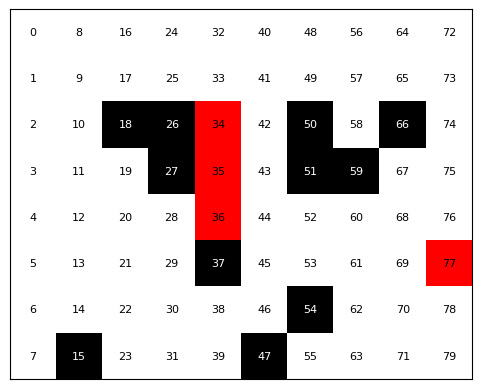

In [5]:
from gymnasium.envs.registration import register

#if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
#    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.05, 'size':[8, 10], 
            'obstacle':[15,18,26,27,37,47,50,51,59,66,54],
            'trap':[34,35,36,77]}  
)
env = gym.make("Gridworld-v0")

# plot the environment
plot_grid(env)


## Transition model / dynamics / Environmental Interactions

Following the problem description on the assignment PDF, implement the ***transition_model***, ***compute_reward***, ***is_done***, and ***step*** functions. Here, 

*   ***is_done*** function determines wether the given next_state terminates the episode or not. 
*   ***step*** function updates its *self.observation* to the next state.

After implementation, please run the cell below to see the histogram of returns.

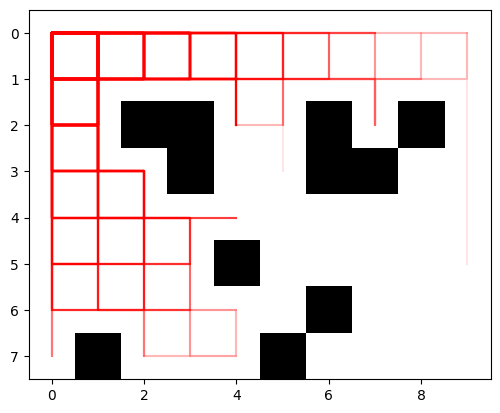

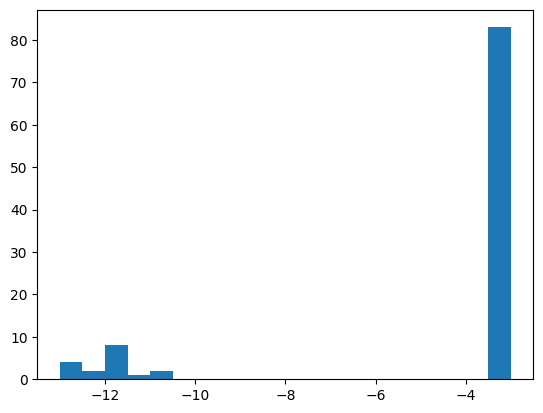

In [6]:
def dummy_policy(state):
    """A dummy random policy"""
    return np.random.choice([1,2,3,4], 1).item()

# Plot the distribution of the collected trajectories
trajs = collect_traj(env, policy=dummy_policy, num_episodes=300)
plot_trajs(env, trajs)

# Plot the histogram of returns after running a dummy policy
returns = eval_policy(env, policy=dummy_policy, num_episodes=100)
plt.hist(returns, bins=20)
plt.show()

Add your code to print out the transition model at a specific coordinate with an action you want. \\
1) print out the transition probabilities to all the next states given a current state $[3,1]$ and a selected action "Down":

In [ ]:
###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
state = [3,1]
p = env.transition_model(env.twod_to_serial(state),2)
###################################################################
print(p.reshape(env.grid_map_shape[::-1]).T)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0125 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0125 0.0125 0.0125 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.95   0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


2) Print out the transition probabilities to all the next states given a current state [0,6] and a selected action "Right":

In [ ]:
###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###

state = [0,6]
p = env.transition_model(env.twod_to_serial(state),4)

###################################################################
print(p.reshape(env.grid_map_shape[::-1]).T)

[[0.     0.     0.     0.     0.     0.0125 0.025  0.95   0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0125 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


3) print out the transition probabilities to all the next states given a current state $[3,5]$ and a selected action "Right":

In [ ]:
###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
state = [3,5]
p = env.transition_model(env.twod_to_serial(state),4)

###################################################################
print(p.reshape(env.grid_map_shape[::-1]).T)

[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0125 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0125 0.9625 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0125 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


# Problem 2: Dynamic Programming (DP)

Great! You can now run an agent to test your MDP implementation.

In [ ]:
###################################################################
##################   DO NOT MODIFY THIS CELL   ####################
###                                                             ###

# You can save a video of 10 episodes that visualizes the average of the returns 
# based on the current (dummy) policy.
saved_run, returns = save_video_of_model("Gridworld-v0", model=dummy_policy, num_episodes=10)
HTML(play_video(saved_run))
###################################################################

Successfully saved 285 frames into Gridworld-v0.mp4!


## (2.1) Value Iteration 
You implement and analyze the value iteration (VI) algorithm filling out ***value_iteration*** and ***get_action*** functions. Please, check the assignment PDF for more details. 

* Hint: you may need to implement your own ***arg_max*** function




In [ ]:
class ValueIteration:
    """
    Value Iteration
    """
    def __init__(self, env,  theta=0.0001, discount_factor=0.9):
        """
        Initialize the VI class

        Parameters
        ----------        
        env: object
            an OpenAI Gym compatible environment
        theta: float
            a max error (termination) threshold 
        discount_factor: float
            discount factor (i.e., gamma)

        Returns
        -------  
        probs: numpy array with a length of {size of state space}
            probabilities of transition to the next_state ...                    
        """      
        self.env = env
        self.V = np.zeros(env.observation_space.n)
        self.discount_factor = discount_factor
        self.theta= theta   # Maximum error thresold value
    
    def value_iteration(self):
        """
        A value iteration function. Until the error bound reaches the threshold 
        (theta), The value table is updated by the Dynamic Programming 
        (refer to the lecture)
        """
        errors = []
        episode_rewards = []
        while True:
            max_error = 0
            for state in range(env.observation_space.n):

                Q = np.zeros(env.action_space.n)
                ###############################################################
                #####################   PLACE YOUR CODE HERE   ################
                ###                                                         ###
                ### Instruction                                             ###
                ### -----------                                             ###
                ### Fill out self.V by using the VI algorithm               ###      
                ###
                ### Example                                                 ###
                ### -----------                                             ###
                ### Initializations
                ### For a in available actions
                ###   For s' in available next states
                ###     Compute reward(s,a,s'), etc
                ###     Compute action value 
                ### Fill out "self.V" at the current state using the action values
                for action in range(self.env.action_space.n):
                  transitions = self.env.transition_model(state, action)
                  for next_state, prob in enumerate(transitions):
                    reward = self.env.compute_reward(state, action, next_state)
                    Q[action] += prob * (reward + self.discount_factor * self.V[next_state])

                max_error = max(max_error, abs(np.max(Q) - self.V[state]))
                self.V[state] = np.max(Q)
                ###                                                         ###
                ###############################################################
                ###############################################################
            errors.append(max_error)
            mean_ep_reward = np.mean( eval_policy(env, policy=self.get_action, num_episodes=10))
            episode_rewards.append(mean_ep_reward)

            if max_error < self.theta:
                break
        return episode_rewards, errors

    def get_action(self, state):
        """
        Return the best action. 
        HINT: how do you handle if there are multiple actions with the highest value?

        Parameters
        ----------        
        state: integer
            a serialized state index

        Returns
        -------  
        action: integer
            an action index
        """

        action = None
        Q = np.zeros(env.action_space.n) # Q values

        ###################################################################
        #####################   PLACE YOUR CODE HERE   ####################
        ###                                                             ###
        ### Instruction                                                 ###
        ### -----------                                                 ###
        ### Find the best "action" that maximize Q value                ###      
        ###                                                             ###  
        ### Example                                                     ###
        ### -----------                                                 ###
        ### Compute Q values when you apply each action                 ###
        ### For a in available actions
        ###   For s' in next states
        ###     Q[a] = ?  
        ###
        ### action = ?  
             
        for action in range(self.env.action_space.n):
          transitions = self.env.transition_model(state, action)
          for next_state, prob in enumerate(transitions):
            reward = self.env.compute_reward(state, action, next_state)
            Q[action]+=prob * (reward + self.discount_factor * self.V[next_state])
            
        max_actions = np.where(Q == np.max(Q))[0]
        action = np.random.choice(max_actions)
        ###                                                             ###
        ###################################################################
        ###################################################################
        return action

After implementation, you can check your implementation with the following code.

In [ ]:
###################################################################
##################   DO NOT MODIFY THIS CELL   ####################
env = gym.make("Gridworld-v0")
vi = ValueIteration(env, discount_factor=0.9)
ep_rews, errors = vi.value_iteration()
###################################################################

You can check the state values of the first 8 states:

In [ ]:
5# the values of the first 10 states of the gridworld environment
print(vi.V[:10])

[ 6.41375913  7.26964833  8.236329    9.31582926 10.52111015 11.86700121
 13.32876639 11.82837033  7.26940132  8.16889617]


You can also overlay the best action at each state and plot the distribution of trajectories produced by the trained VI policy:

Successfully saved 186 frames into Gridworld-v0.mp4!


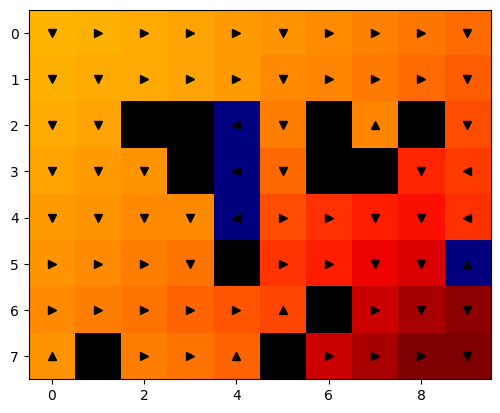

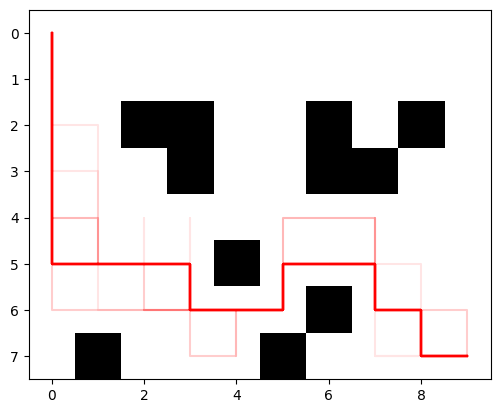

In [ ]:
## Visualize the policy with the value map and trajectories plot
saved_run, _ = save_video_of_model("Gridworld-v0", vi.get_action)
render_value_map_with_action(env, vi.V, vi.get_action)
HTML(play_video(saved_run))
trajs = collect_traj(env, policy=vi.get_action, num_episodes=100)
plot_trajs(env, trajs)

You can also plot the expected returns and errors with respect to the number of iterations until convergence:

<ipython-input-15-38728b8c08c5>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(empty_string_labels)


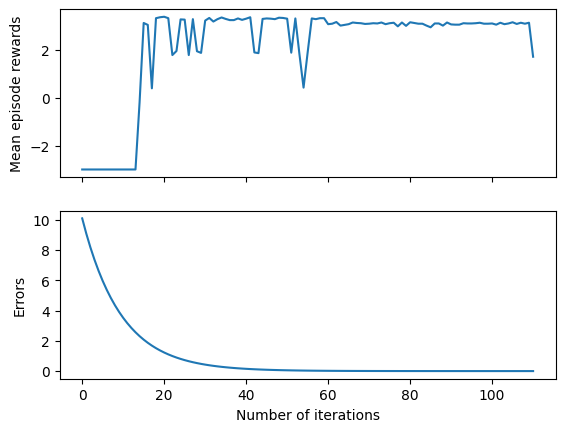

In [ ]:
## Plot error and mean episodic rewards per iterations
def plot_reward_error_graphs(ep_rews, errors):
    ax = plt.subplot(2,1,1)
    ax.plot(ep_rews)
    bx = plt.subplot(2,1,2)
    bx.plot(errors)
    ax.set_ylabel('Mean episode rewards')
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    bx.set_xlabel('Number of iterations')
    bx.set_ylabel('Errors')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)

    plt.show()

plot_reward_error_graphs(ep_rews, errors)

## (2.2) Comparison under different transition models

Here, you need to vary $\epsilon$. Get the necessary results when $\epsilon=0.1$:

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment Gridworld-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


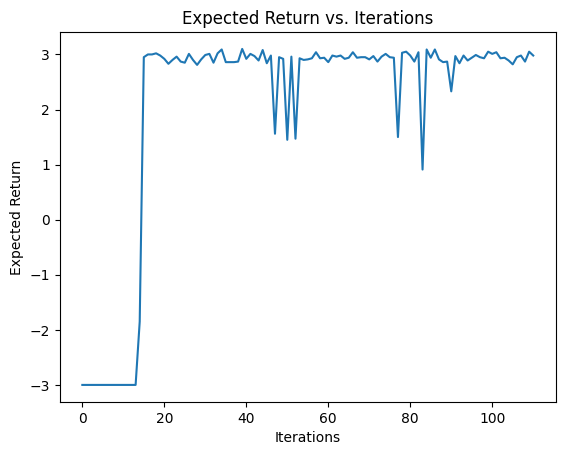

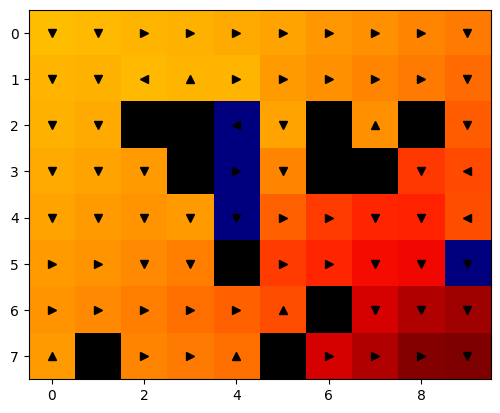

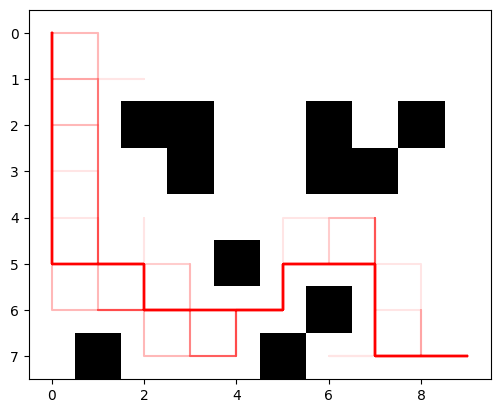

In [ ]:
###################################################################
##################   DO NOT MODIFY THIS CELL   ####################
###
#if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
#    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.1, 'size':[8, 10], 
            'obstacle':[15,18,26,27,37,47,50,51,59,66,54],
            'trap':[34,35,36,77]}  
)                                            
env = gym.make("Gridworld-v0")

vi = ValueIteration(env, discount_factor=0.9)
ep_rews, errors2 = vi.value_iteration()
###################################################################

###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
### 1. plot the expected return                                 ###
### 2. render the value map overlaying the best action          ###
### 3. Plot the distribution of trajectories                    ###

# Plot error and mean episodic rewards per iterations


# Visualize the policy with the value map and trajectories plot
def vi_policy(state):
    return vi.get_action(state)

plt.figure()
plt.plot(ep_rews)
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
plt.title('Expected Return vs. Iterations')
plt.show()

render_value_map_with_action(env, vi.V, vi.get_action)


trajs_vi = collect_traj(env, policy=vi_policy, num_episodes=100)
plot_trajs(env, trajs_vi)



###################################################################

Get the necessary results when $\epsilon=0.4$:

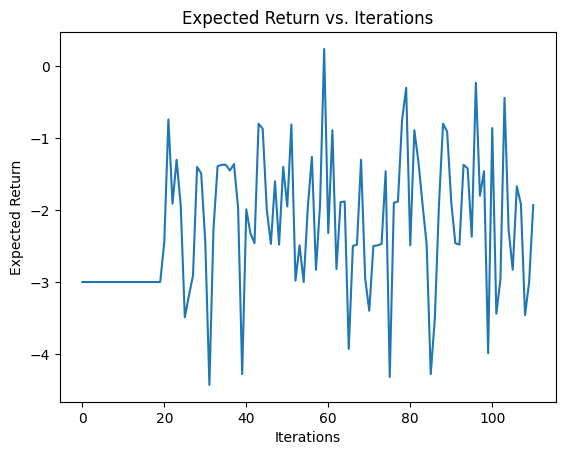

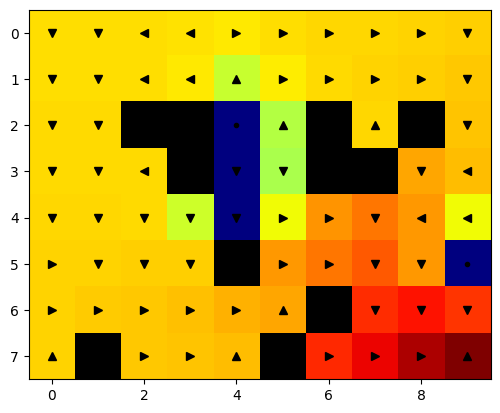

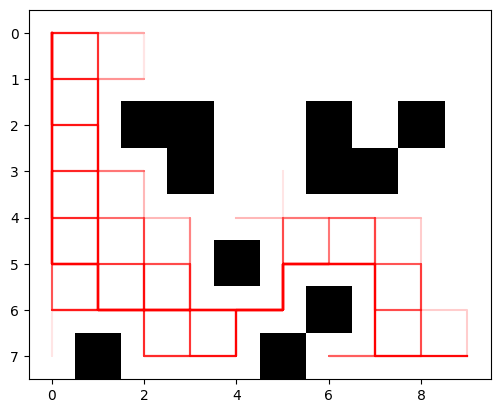

In [ ]:
###################################################################
##################   DO NOT MODIFY THIS CELL   ####################
###
#if 'Gridworld-v0' in gym.envs.registration.registry.env_specs:
#    del gym.envs.registration.registry.env_specs['Gridworld-v0']
register(
    id='Gridworld-v0',
    entry_point=GridEnv,
    max_episode_steps=30,
    reward_threshold=100,
    kwargs={'epsilon':0.4, 'size':[8, 10], 
            'obstacle':[15,18,26,27,37,47,50,51,59,66,54],
            'trap':[34,35,36,77]}  
)                                            
env = gym.make("Gridworld-v0")

vi = ValueIteration(env, discount_factor=0.9)
ep_rews, errors = vi.value_iteration()
###################################################################

###################################################################
#####################   PLACE YOUR CODE HERE   ####################
###                                                             ###
### 1. plot the expected return                                 ###
### 2. render the value map overlaying the best action          ###
### 3. Plot the distribution of trajectories                    ###

# Plot error and mean episodic rewards per iterations


# Visualize the policy with the video and trajectories plot

plt.figure()
plt.plot(ep_rews)
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
plt.title('Expected Return vs. Iterations')
plt.show()

render_value_map_with_action(env, vi.V, vi.get_action)


trajs_vi = collect_traj(env, policy=vi_policy, num_episodes=100)
plot_trajs(env, trajs_vi)



###################################################################